# Text Classification

Text classification is one of the tasks that is addressed in natural language processing (NLP).  Like with computer vision, NLP uses deep learning.  A particular kind of deep learning model that is used in NLP is called the transformer.  If you're interested in learning  about transformers in this [blog post](http://jalammar.github.io/illustrated-transformer/).  We'll be using an implementation of transformers from an open source package called Hugging Face.  

For this assignment, we'll look at wallk through a text classification task called *intent detection*.  When you talk to your Amazon Alexa, it needs to figure out what you're trying to do.  Are you trying to play music?  Do you want to check the weather?  Are you setting a timer?  Are you trying to get a recipe to cook something?  Depending on what it thinks your intent is, it routes your message to a specialized module to handle your request.


### Let's get started!

Run the following cells to download the dataset and preprocess it.

In [ ]:
#@title Run me and restart runtime environment!
###################### Restart Runtime after executing this cell ######################################################
# !export CUDA_LAUNCH_BLOCKING=1
!pip install simpletransformers

In [ ]:
#@title Run me! – Data Preprocessing 1 
###**Do not modify the code in the cells below (I am planning to remove some of the below cells used for preperocessing and subsettng the data and provide the final csv to the students instead)**
### gathering the dataset
from urllib.request import urlretrieve
from pathlib import Path
import pandas as pd

SNIPS_DATA_BASE_URL = (
    "https://github.com/ogrisel/slot_filling_and_intent_detection_of_SLU/blob/"
    "master/data/snips/"
)
for filename in ["train", "valid", "vocab.intent"]:
    path = Path(filename)
    if not path.exists():
        print(f"Downloading {filename}...")
        urlretrieve(SNIPS_DATA_BASE_URL + filename + "?raw=true", path)

In [ ]:
#@title Run me! – Data Preprocessing 2
### gathering the dataset
def parse_line(line):
    utterance_data, intent_label = line.split(" <=> ")
    items = utterance_data.split()
    words = [item.rsplit(":", 1)[0]for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": intent_label,
        "words": " ".join(words),
        "word_labels": " ".join(word_labels),
        "length": len(words),
    }

## Intent Classification Dataset 

In this part of the assignment, we will be using a subset of [intent classifcation dataset 
](https://github.com/ogrisel/slot_filling_and_intent_detection_of_SLU/tree/master/data/snips). We will be classifying a given sentence into one of the five categories:
AddToPlaylist,
BookRestaurant,
GetWeather,
PlayMusic and 
RateBook.

We will also provided a separate validation set to test the performance of the model. In the next cells, the data will be cleaned for you to use.


In [ ]:
#@title Run me! – Data Cleaning & First 5 Rows of Dataset
################ data cleaning #############
intent_names = Path("vocab.intent").read_text().split()
intent_names=intent_names[0:1]+intent_names[3:4]
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))

lines_train = Path("train").read_text().strip().splitlines()

parsed = [parse_line(line) for line in lines_train]

df_train = pd.DataFrame([p for p in parsed if p is not None])

## getting a subset of data
count=500 
#df_train_small= pd.concat([df_train[0:0+count],df_train[1842:1842+count],df_train[3715:3715+count],df_train[5615:5615+count],df_train[7515:7515+count],df_train[9371:9371+count],df_train[11225:11225+count]]) 

df_train_= pd.concat([df_train[0:0+count],df_train[5615:5615+count]]) 

df_train_=df_train_[['words','intent_label']]

df_train_.replace({"intent_label":intent_map },inplace=True)

df_train_=df_train_.sample(frac=1,random_state=56132).reset_index(drop=True)

df_train_.head()


## introducing noise
df_1=df_train_.sample(frac=0.3,random_state=111)

df_0=df_train_.sample(frac=0.3,random_state=80)

df_train_.loc[df_0.index ,'intent_label'] = 0
df_train_.loc[df_1.index ,'intent_label'] = 1


df_train_['intent_label'].value_counts()




,words,intent_label
0,Play a song off Ian Stuart Donaldson 's Nature...,1
1,add an album to playlist Emily Dickinson,0
2,A Shawnna to the Warm Hearts Feel Good playlist.,0
3,Play some music using slacker,1
4,Can you play Maggie Mae on Netflix,1


Awesome, we're all set to get started with the actual analysis! In the next step, we will split the training and test data using the sklearn train_test_split function (see how it works [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). To decrease the training time (our current dataset has 9000 rows!), we will create a smaller subset of the training data called df_train_small. Note here that the parameter 'train_size' and 'test_size' indicate the proportion of data that is used for the training/testing dataset respectively. More information can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).


In [ ]:
 from sklearn.model_selection import train_test_split  

def subset_datafarme(train_size):       
        X=df_train_['words']
        y=df_train_['intent_label']
        X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=train_size, stratify=y,random_state=444)
        df_train_small=pd.DataFrame({'words':X_train,'intent_label':y_train})

        return df_train_small

By running the following cell, you can see the intent map, i.e. which intent is mapped to which label:

In [ ]:
intent_map

{'AddToPlaylist': 0, 'PlayMusic': 1}

In [ ]:
#@title Run me! – Validation Set Cleaning & First 5 Rows of Dataset

### cleaning validation set.
lines_valid = Path("valid").read_text().strip().splitlines()
df_valid = pd.DataFrame([parse_line(line) for line in lines_valid])
count=50
df_valid= pd.concat([df_valid[0:0+count],df_valid[300:300+count]]) 
df_valid=df_valid.sample(frac=1,random_state=1234).reset_index(drop=True)
df_valid=df_valid[['words','intent_label']]
df_valid.replace({"intent_label":intent_map },inplace=True)
df_valid.head()


## Defining the transformer model 
We will be using [Simple Transformers](https://github.com/ThilinaRajapakse/simpletransformers) to train our model. They are a wrapper library based on the [Transformer](https://github.com/huggingface/transformers) library of Hugging face. It let's you solve many interesting NLP problems with a few lines of code. Initially, we define the model. Here we've used the 'Bert Model' for training our classifier, but you can also try it with other [pre-trained models](https://huggingface.co/transformers/pretrained_models.html).

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

model_args = ClassificationArgs(num_train_epochs=1, overwrite_output_dir=True, manual_seed=42)
model = ClassificationModel(model_type='bert', model_name='bert-base-uncased', use_cuda=False, num_labels=2, args=model_args)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

After it has been us talking for some time, it's your turn! Write a function "get_labels" that takes as input a prediction and returns the corresponding intent from the intent map that you saw above. This essentially means that if the input to the get_labels function is 0, it should return "AddToPlaylist" and if it is 1, it should return "PlayMusic"

In [ ]:
## TO DO: Write the get_labels function that converts the numerical predictions (0 or 1) to the actual labels (AddToPlaylist or PlayMusic)
## You can either hard code the solution or – for a bit more challenging and in real-life more expandable implementation – try to use the mapping that is stored in the intent_map that we saw earlier!

def get_labels(predictions):
    labels = ...
    return labels

Good job! Now that we have that, we'll train our model. To ensure that training won't take too long, we set the training dataset size to be 0.1. There is a gap (indicated by the three dots) in the code for you to fill out though before we can continue :)

In [ ]:
train_size=0.1
df_train_small= subset_datafarme(train_size)
df_train_small.shape

## Training the model
## TO DO: Add the missing input parameter
model.train_model(...)

## Evaluate model
result, model_outputs, wrong_predictions = model.eval_model(df_valid)

## Print the loss

print(result['eval_loss'])

Now we finally get to the fun part – using our model to predict the intent of a sentence! Again, we have left some gaps for you to fill:

In [ ]:
## These are the sentences we make predictions for like "Play forties music on Pandora" or "Play the song domino by Luca Turilli". 
## TO DO: Add two relevant prediction sentences like the ones above in string format to the prediction_sentence array (where the three dots are)

prediction_sentences=["...",
                      "..."]

## TO DO: Fill out the missing input parameter for the predict function and see whether you can actually get predictions for your
## defined sentences!

predictions, raw_outputs = model.predict(...)

## With the following lines, we'll translate the predictions back to the intent using the get_labels function you designed earlier
for i in range(len(prediction_sentences)):
    print(prediction_sentences[i],":",get_labels(predictions[i]))

That's another step done and dusted :) Now it's time to see how our model is doing overall by examining the accuracy scores. First, we will define a function to obtain the accuracy of our model:

In [ ]:
from sklearn.metrics import accuracy_score

def accuracy_model(model,df_train_small):
    model.train_model(df_train_small)
   #result, model_outputs, wrong_predictions = model.eval_model(df_valid)
    predictions, raw_outputs = model.predict(df_valid['words'])
    return  accuracy_score(df_valid['intent_label'],predictions)


Next, we'll train the model with different training data sizes and save both the accuracy obtained (saved in accuracy_plot) and the size of the dataset (saved in train_shape) so that we can plot it later. Try it out with a couple of training sizes yourself – add four to five values between 0 and 1 to the training size array and see how your plot in the next cell changes!

In [ ]:
## TO DO: Add different training sizes between 0 and 1
train_sizes=[..., ..., ..., ..., ...]

train_shape=[]
accuracy_plot=[]
for train_size in train_sizes:    
    df_train_small=subset_datafarme(train_size)    
    acc=accuracy_model(model,df_train_small)
    print(train_size,len(df_train_small),acc)
    accuracy_plot.append(acc)
    train_shape.append(len(df_train_small))


And lastly, we want to plot the training size against the accuracy obtained. You know the game, fill out the input parameters to plot the size of the dataset on the x-axis and the accuracy on the y-axis:

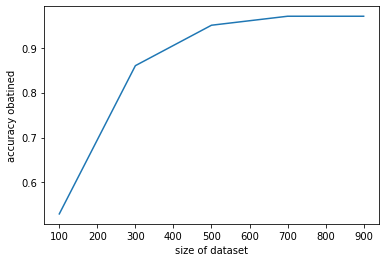

In [ ]:
import matplotlib.pyplot as plt

## TO DO: Add the missing input parameters
plt.plot(..., ...)
plt.xlabel("size of dataset")
plt.ylabel("accuracy obatined")
plt.show()

Good job, you're done with this part of the assignment!